In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Accelerating VQEs with quantum natural gradient
===============================================

::: {.meta}
:property=\"og:description\": Accelerating variational quantum
eigensolvers using quantum natural gradients in PennyLane.
:property=\"og:image\":
<https://pennylane.ai/qml/_images/qng_example.png>
:::

::: {.related}
tutorial\_vqe A brief overview of VQE
tutorial\_quantum\_natural\_gradient Quantum natural gradient
:::

*Authors: Maggie Li, Lana Bozanic, Sukin Sim --- Posted: 06 November
2020. Last updated: 08 April 2021.*

This tutorial showcases how one can apply quantum natural gradients
(QNG) to accelerate the optimization step of the Variational Quantum
Eigensolver (VQE) algorithm. We will implement two small examples:
estimating the ground state energy of a single-qubit VQE problem, which
we can visualize using the Bloch sphere, and the hydrogen molecule.

Before going through this tutorial, we recommend that readers refer to
the
`QNG tutorial </demos/tutorial_quantum_natural_gradient>`{.interpreted-text
role="doc"} and `VQE tutorial </demos/tutorial_vqe>`{.interpreted-text
role="doc"} for overviews of quantum natural gradient and the
variational quantum eigensolver algorithm, respectively. Let\'s get
started!

Single-qubit VQE example
------------------------

The first step is to import the required libraries and packages:


In [1]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

# import numpy as np
from numpy.linalg import eig

For this simple example, we consider the following single-qubit
Hamiltonian: $\sigma_x + \sigma_z$.

We define the device:


In [29]:
# Set up the parameters
qubits = 4  # grid size

n = qubits
dx = 1.0/n  # grid spacing

# Set up the difference operator
D = np.zeros((n**2, n**2))
for i in range(n):
    for j in range(n):
        k = i*n + j
        if i > 0:
            D[k, (i-1)*n + j] += 1
        if i < n-1:
            D[k, (i+1)*n + j] += 1
        if j > 0:
            D[k, i*n + j-1] += 1
        if j < n-1:
            D[k, i*n + j+1] += 1
        D[k, k] -= 4

# # Print the final solution
print(D)

l, v = eig(D)

print('\n', l)

print('\n', sorted(l))

print('\n', v)

# print('\n', v)

# Make histogram

[[-4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4. 

In [30]:
H = qml.pauli_decompose(D)

print(H)

  (-4.0) [I0 I1 I2 I3]
+ (0.5) [I0 I1 X2 X3]
+ (0.5) [I0 I1 Y2 Y3]
+ (0.5) [X0 X1 I2 I3]
+ (0.5) [Y0 Y1 I2 I3]
+ (1.0) [I0 I1 I2 X3]
+ (1.0) [I0 X1 I2 I3]


In [36]:
dev = qml.device("default.qubit", wires=4)

For the variational ansatz, we use two single-qubit rotations, which the
user may recognize from a previous
`tutorial </demos/tutorial_qubit_rotation>`{.interpreted-text
role="doc"} on qubit rotations.


In [37]:
def circuit(params, wires=4):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RX(params[2], wires=1)
    qml.RY(params[3], wires=1)
    qml.RX(params[4], wires=2)
    qml.RY(params[5], wires=2)
    qml.RX(params[6], wires=3)
    qml.RY(params[7], wires=3)
#     qml.RX(params[8], wires=4)
#     qml.RY(params[9], wires=4)
#     qml.RX(params[10], wires=5)
#     qml.RY(params[11], wires=5)
    
#     qml.RX(params, wires=0)
#     qml.RY(params, wires=0)
#     qml.RX(params, wires=1)
#     qml.RY(params, wires=1)
#     qml.RX(params, wires=2)
#     qml.RY(params, wires=2)
#     qml.RX(params, wires=3)
#     qml.RY(params, wires=3)
#     qml.RX(params, wires=4)
#     qml.RY(params, wires=4)
#     qml.RX(params, wires=5)
#     qml.RY(params, wires=5)
    
#     qml.RX(params[0], wires=1)
#     qml.RY(params[1], wires=1)
    
    # return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [38]:
# Wieghts

#Lower values of weights seems to be a little better

randw = np.random.uniform(0.0001,2,8)

print(randw)

# for 4 qubits 0.5554565  [1.34757202 1.96211005 1.12726619] convereged to approx -5.5

# [1.26190158 0.23128387 0.4608764  0.62664839 0.02505982 1.94600236 1.11482688 0.842671  ]

[1.26190158 0.23128387 0.4608764  0.62664839 0.02505982 1.94600236
 1.11482688 0.842671  ]


We then define our cost function which supports the computation of
block-diagonal or diagonal approximations to the Fubini-Study metric
tensor. This tensor is a crucial component for optimizing with quantum
natural gradients.


In [39]:
# coeffs = [1, 1]
# obs = [qml.PauliX(0), qml.PauliZ(0)]

# H = qml.Hamiltonian(coeffs, obs)

# print(H)

In [40]:
@qml.qnode(dev, interface="autograd")
def cost_fn(params):
    circuit(params)
    return qml.expval(H)

In [41]:
# print(qml.draw(circuit, show_matrices=True)())

To analyze the performance of quantum natural gradient on VQE
calculations, we set up and execute optimizations using the
`GradientDescentOptimizer` (which does not utilize quantum gradients)
and the `QNGOptimizer` that uses the block-diagonal approximation to the
metric tensor.

To perform a fair comparison, we fix the initial parameters for the two
optimizers.


In [42]:
init_params = np.array(randw, requires_grad=True)

# init_params = np.array([5.734882373784, 6.83295389245837, 4.832957289573298, 1.238974829785927398], requires_grad=True)

# init_params = np.array([4.97507603, 3.00854038, 5.339499404, 4.3929304], requires_grad=True)

# init_params = np.array([3.97507603, 3.00854038], requires_grad=True)

We will carry out each optimization over a maximum of 500 steps. As was
done in the VQE tutorial, we aim to reach a convergence tolerance of
around $10^{-6}$. We use a step size of 0.01.


In [47]:
max_iterations = 1000
conv_tol = 0.001
step_size = 0.1

First, we carry out the VQE optimization using the standard gradient
descent method.


In [51]:
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

for i in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if i % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(i, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Lowest eigen value = {:.3f} ".format(min(l)))
print("Number of iterations = ", i)

Iteration = 0,  Energy = -2.94686693 Ha,  Convergence parameter = 0.19503699 Ha
Iteration = 20,  Energy = -6.39792311 Ha,  Convergence parameter = 0.05392891 Ha
Iteration = 40,  Energy = -6.72335545 Ha,  Convergence parameter = 0.00839695 Ha
Iteration = 60,  Energy = -6.87840675 Ha,  Convergence parameter = 0.00652515 Ha
Iteration = 80,  Energy = -6.96372572 Ha,  Convergence parameter = 0.00243640 Ha

Final value of the energy = -6.98552327 Ha
Lowest eigen value = -7.236 
Number of iterations =  94


We then repeat the process for the optimizer employing quantum natural
gradients:


In [240]:
opt = qml.QNGOptimizer(stepsize=step_size, approx="block-diag")

params = init_params

qngd_param_history = [params]
qngd_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    # Compute energy
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if i % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(i, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", i)

LinAlgError: Singular matrix

Visualizing the results
=======================

For single-qubit examples, we can visualize the optimization process in
several ways.

For example, we can track the energy history:


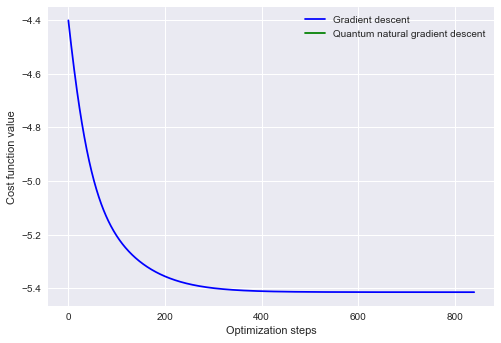

In [77]:
plt.style.use("seaborn")
plt.plot(gd_cost_history, "b", label="Gradient descent")
plt.plot(qngd_cost_history, "g", label="Quantum natural gradient descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Or we can visualize the optimization path in the parameter space using a
contour plot. Energies at different grid points have been pre-computed,
and they can be downloaded by clicking
`here<../demonstrations/vqe_qng/param_landscape.npy>`{.interpreted-text
role="download"}.


In [11]:
# Discretize the parameter space
theta0 = np.linspace(0.0, 2.0 * np.pi, 100)
theta1 = np.linspace(0.0, 2.0 * np.pi, 100)

# Load energy value at each point in parameter space
parameter_landscape = np.load("vqe_qng/param_landscape.npy")

# Plot energy landscape
fig, axes = plt.subplots(figsize=(6, 6))
cmap = plt.cm.get_cmap("coolwarm")
contour_plot = plt.contourf(theta0, theta1, parameter_landscape, cmap=cmap)
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")

# Plot optimization path for gradient descent. Plot every 10th point.
gd_color = "g"
plt.plot(
    np.array(gd_param_history)[::10, 0],
    np.array(gd_param_history)[::10, 1],
    ".",
    color=gd_color,
    linewidth=1,
    label="Gradient descent",
)
plt.plot(
    np.array(gd_param_history)[:, 0],
    np.array(gd_param_history)[:, 1],
    "-",
    color=gd_color,
    linewidth=1,
)

# Plot optimization path for quantum natural gradient descent. Plot every 10th point.
qngd_color = "k"
plt.plot(
    np.array(qngd_param_history)[::10, 0],
    np.array(qngd_param_history)[::10, 1],
    ".",
    color=qngd_color,
    linewidth=1,
    label="Quantum natural gradient descent",
)
plt.plot(
    np.array(qngd_param_history)[:, 0],
    np.array(qngd_param_history)[:, 1],
    "-",
    color=qngd_color,
    linewidth=1,
)

plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'vqe_qng/param_landscape.npy'

Here, the blue regions indicate states with lower energies, and the red
regions indicate states with higher energies. We can see that the
`QNGOptimizer` takes a more direct route to the minimum in larger
strides compared to the path taken by the `GradientDescentOptimizer`.

Lastly, we can visualize the same optimization paths on the Bloch sphere
using routines from [QuTiP](http://qutip.org/). The result should look
like the following:

![](/demonstrations/vqe_qng/opt_paths_bloch.png){.align-center
width="50.0%"}

where again the black markers and line indicate the path taken by the
`QNGOptimizer`, and the green markers and line indicate the path taken
by the `GradientDescentOptimizer`. Using this visualization method, we
can clearly see how the path using the `QNGOptimizer` tightly \"hugs\"
the curvature of the Bloch sphere and takes the shorter path.

Now, we will move onto a more interesting example: estimating the ground
state energy of molecular hydrogen.

Hydrogen VQE Example
====================

To construct our system Hamiltonian, we first read the molecular
geometry from the external file
`h2.xyz </demonstrations/h2.xyz>`{.interpreted-text role="download"}
using the `~.pennylane.qchem.read_structure`{.interpreted-text
role="func"} function (see more details in the
`tutorial_quantum_chemistry`{.interpreted-text role="doc"} tutorial).
The molecular Hamiltonian is then built using the
`~.pennylane.qchem.molecular_hamiltonian`{.interpreted-text role="func"}
function.


In [12]:
geo_file = "h2.xyz"

symbols, coordinates = qml.qchem.read_structure(geo_file)
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

print("Number of qubits = ", qubits)

FileNotFoundError: [Errno 2] No such file or directory: 'h2.xyz'

For our ansatz, we use the circuit from the [VQE
tutorial](https://pennylane.ai/qml/demos/tutorial_vqe.html) but expand
out the arbitrary single-qubit rotations to elementary gates (RZ-RY-RZ).


In [ ]:
dev = qml.device("default.qubit", wires=qubits)
hf_state = np.array([1, 1, 0, 0], requires_grad=False)

def ansatz(params, wires=[0, 1, 2, 3]):
    qml.BasisState(hf_state, wires=wires)
    for i in wires:
        qml.RZ(params[3 * i], wires=i)
        qml.RY(params[3 * i + 1], wires=i)
        qml.RZ(params[3 * i + 2], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

Note that the qubit register has been initialized to $|1100\rangle$,
which encodes for the Hartree-Fock state of the hydrogen molecule
described in the minimal basis. Again, we define the cost function to be
the following QNode that measures `expval(H)`:


In [ ]:
@qml.qnode(dev, interface="autograd")
def cost(params):
    ansatz(params)
    return qml.expval(hamiltonian)

For this problem, we can compute the exact value of the ground state
energy via exact diagonalization. We provide the value below.


In [ ]:
exact_value = -1.136189454088

We now set up our optimizations runs.


In [ ]:
np.random.seed(0)
init_params = np.random.uniform(low=0, high=2 * np.pi, size=12, requires_grad=True)
max_iterations = 500
step_size = 0.5
conv_tol = 1e-06

As was done with our previous VQE example, we run the standard gradient
descent optimizer.


In [ ]:
opt = qml.GradientDescentOptimizer(step_size)

params = init_params

gd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    gd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

    if conv <= conv_tol:
        break


print()
print("Final convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Next, we run the optimizer employing quantum natural gradients. We also
need to make the Hamiltonian coefficients non-differentiable by setting
`requires_grad=False`.


In [ ]:
hamiltonian = qml.Hamiltonian(np.array(hamiltonian.coeffs, requires_grad=False), hamiltonian.ops)

opt = qml.QNGOptimizer(step_size, lam=0.001, approx="block-diag")

params = init_params
prev_energy = cost(params)
qngd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    qngd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 4 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

    if conv <= conv_tol:
        break


print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Visualizing the results
=======================

To evaluate the performance of our two optimizers, we can compare: (a)
the number of steps it takes to reach our ground state estimate and (b)
the quality of our ground state estimate by comparing the final
optimization energy to the exact value.


In [ ]:
plt.style.use("seaborn")
plt.plot(np.array(gd_cost) - exact_value, "g", label="Gradient descent")
plt.plot(np.array(qngd_cost) - exact_value, "k", label="Quantum natural gradient descent")
plt.yscale("log")
plt.ylabel("Energy difference")
plt.xlabel("Step")
plt.legend()
plt.show()

We see that by employing quantum natural gradients, it takes fewer steps
to reach a ground state estimate and the optimized energy achieved by
the optimizer is lower than that obtained using vanilla gradient
descent.


Robustness in parameter initialization
======================================

While results above show a more rapid convergence for quantum natural
gradients, what if we were just lucky, i.e., we started at a \"good\"
point in parameter space? How do we know this will be the case with high
probability regardless of the parameter initialization?

Using the same system Hamiltonian, ansatz, and device, we tested the
robustness of the `QNGOptimizer` by running 10 independent trials with
random parameter initializations. For this numerical test, our optimizer
does not terminate based on energy improvement; we fix the number of
iterations to 200. We show the result of this test below (after
pre-computing), where we plot the mean and standard deviation of the
energies over optimization steps for quantum natural gradient and
standard gradient descent.

![](../demonstrations/vqe_qng/k_runs_.png){.align-center width="60.0%"}

We observe that quantum natural gradient on average converges faster for
this system.

::: {.note}
::: {.title}
Note
:::

While using QNG may help accelerate the VQE algorithm in terms of
optimization steps, each QNG step is more costly than its vanilla
gradient descent counterpart due to a greater number of calls to the
quantum computer that are needed to compute the Fubini-Study metric
tensor.
:::

While further benchmark studies are needed to better understand the
advantages of quantum natural gradient, preliminary studies such as this
tutorial show the potentials of the method. 🎉


References
==========

About the authors
=================
